In [1]:
import os, types
import matplotlib.pyplot as plt
import pandas as pd
from io import BytesIO
import zipfile
from botocore.client import Config
import ibm_boto3
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,LeakyReLU, Dropout
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_169d2a0a2250458b858e1cef9144e967 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='7774SFgyrRwoZn1kHE2AwmcLSPp1Qdcrzvq0o7Y0aVak',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

streaming_body_1 = client_169d2a0a2250458b858e1cef9144e967.get_object(Bucket='cricketposedetection-donotdelete-pr-vw7jgzldajokea', Key='data.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [3]:
unzip=zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,vertical_flip=False)

In [5]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
x_train=train_datagen.flow_from_directory(r"data/train",target_size=(64,64),class_mode='categorical',batch_size=32)

Found 2250 images belonging to 10 classes.


In [7]:
x_test=test_datagen.flow_from_directory(r"data/test",target_size=(64,64),class_mode='categorical',batch_size=16)

Found 250 images belonging to 10 classes.


In [8]:
x_train.class_indices

{'bowling': 0,
 'catch': 1,
 'cover drive': 2,
 'dive': 3,
 'flick': 4,
 'pull shot': 5,
 'scoop shot': 6,
 'square cut': 7,
 'straight drive': 8,
 'sweep': 9}

In [9]:
model=Sequential()
model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation=LeakyReLU(),padding='same'))
model.add(Convolution2D(32,(3,3),input_shape=(64,64,32),activation=LeakyReLU(),padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Convolution2D(64,(3,3),input_shape=(32,32,32),activation='relu',padding='same'))
model.add(Convolution2D(128,(3,3),input_shape=(32,32,64),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856     
                                                        

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [12]:
filepath = 'cricket.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True,mode='max')
stop=EarlyStopping(monitor="val_accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)
callbacks = [checkpoint,stop]
output=model.fit_generator(x_train,steps_per_epoch=len(x_train),callbacks=callbacks,epochs=70,validation_data=x_test,validation_steps=len(x_test))

/tmp/wsuser/ipykernel_4749/1979097995.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  output=model.fit_generator(x_train,steps_per_epoch=len(x_train),callbacks=callbacks,epochs=70,validation_data=x_test,validation_steps=len(x_test))


Epoch 1/70
71/71 [==============================] - ETA: 0s - loss: 2.4733 - accuracy: 0.1329
Epoch 00001: val_accuracy improved from -inf to 0.10400, saving model to cricket.hdf5
71/71 [==============================] - 25s 334ms/step - loss: 2.4733 - accuracy: 0.1329 - val_loss: 2.2961 - val_accuracy: 0.1040
Epoch 2/70
71/71 [==============================] - ETA: 0s - loss: 2.1804 - accuracy: 0.2080
Epoch 00002: val_accuracy improved from 0.10400 to 0.30800, saving model to cricket.hdf5
71/71 [==============================] - 22s 313ms/step - loss: 2.1804 - accuracy: 0.2080 - val_loss: 2.0005 - val_accuracy: 0.3080
Epoch 3/70
71/71 [==============================] - ETA: 0s - loss: 1.9923 - accuracy: 0.2929
Epoch 00003: val_accuracy improved from 0.30800 to 0.32000, saving model to cricket.hdf5
71/71 [==============================] - 22s 313ms/step - loss: 1.9923 - accuracy: 0.2929 - val_loss: 1.9358 - val_accuracy: 0.3200
Epoch 4/70
71/71 [==============================] - ETA: 0

Epoch 29/70
71/71 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8627
Epoch 00029: val_accuracy did not improve from 0.55600
71/71 [==============================] - 22s 309ms/step - loss: 0.4189 - accuracy: 0.8627 - val_loss: 2.4463 - val_accuracy: 0.5400
Epoch 30/70
71/71 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8609
Epoch 00030: val_accuracy did not improve from 0.55600
71/71 [==============================] - 22s 309ms/step - loss: 0.4231 - accuracy: 0.8609 - val_loss: 2.3371 - val_accuracy: 0.5440
Epoch 31/70
71/71 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8613
Epoch 00031: val_accuracy did not improve from 0.55600
71/71 [==============================] - 22s 304ms/step - loss: 0.4015 - accuracy: 0.8613 - val_loss: 2.8346 - val_accuracy: 0.5000
Epoch 32/70
71/71 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8751
Epoch 00032: val_accuracy did not improve from 0.55600
Rest

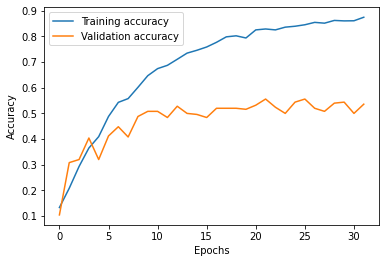

In [13]:
plt.plot(output.history['accuracy'], label='Training accuracy')
plt.plot(output.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

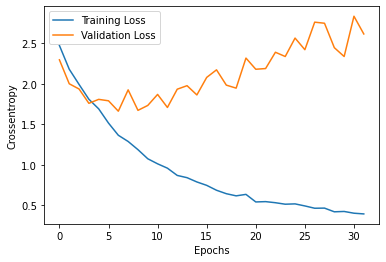

In [14]:
plt.plot(output.history['loss'], label='Training Loss')
plt.plot(output.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Crossentropy')
plt.show()

In [15]:
!ls

cricketcnn.tgz	cricket.hdf5  cricket.tgz  data


In [16]:
!pip install watson-machine-learning-client

In [17]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"tJxpvrqFLqoZt_x5PErYhOMhGHYfrGvrZjYdsHfrm9xf"
}

In [18]:
client=APIClient(wml_credentials)
client

In [19]:
def uid_space_name(client,Cricket_deploy):
    space=client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']['name']==Cricket_deploy)['metadata']['id'])

In [20]:
space_uid=uid_space_name(client,'Cricket_Pose_Classification')
print(space_uid)

adf8a556-c2c8-4c26-a677-eac86b7a77a9


In [21]:
client.set.default_space(space_uid)

'SUCCESS'

In [22]:
client.software_specifications.list(200)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1

In [23]:
software_space_uid=client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [24]:
!tar -zcvf cricket.tgz cricket.hdf5

cricket.hdf5


In [25]:
model_details=client.repository.store_model(model='cricket.tgz',
                                           meta_props={
                                               client.repository.ModelMetaNames.NAME:"CNN Model",
                                               client.repository.ModelMetaNames.TYPE:'tensorflow_2.7',
                                               client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
                                           })

In [26]:
model_id=client.repository.get_model_id(model_details)

In [27]:
model_id

'e5268ec5-890a-4c80-8460-2d07445de608'

In [29]:
client.repository.download(model_id,'cricketcnn1.tgz')

Successfully saved model content to file: 'cricketcnn1.tgz'


'/home/wsuser/work/cricketcnn1.tgz'

In [30]:
ls

cricketcnn1.tgz  cricketcnn.tgz  cricket.hdf5  cricket.tgz  data/
